In [88]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
import numpy as np
import matplotlib.pyplot as plt

from gym_microrts import microrts_ai
from gym_microrts.envs.vec_env import MicroRTSGridModeVecEnv

from llm.nashor import Nashor

from gus.utils import save_video


# Game Lifecycle

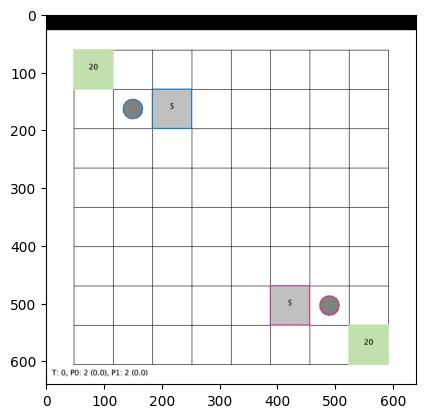

In [94]:
max_steps = 2000
map_size = 8
no_action = np.zeros((1, map_size*map_size, 78))

envs = MicroRTSGridModeVecEnv(
    num_selfplay_envs=0,
    num_bot_envs=1,
    max_steps=max_steps,
    render_theme=2,
    ai2s=[microrts_ai.passiveAI for _ in range(1)],
    # ai2s=[microrts_ai.randomAI for _ in range(1)],
    # ai2s=[microrts_ai.naiveMCTSAI for _ in range(1)],
    # ai2s=[microrts_ai.coacAI for _ in range(1)],
    # map_paths=["maps/4x4/base4x4.xml"],
    map_paths=["maps/8x8/basesWorkers8x8.xml"],
    # map_paths=["maps/8x8/melee8x8Mixed7.xml"],
    reward_weight=np.array([10.0, 1.0, 1.0, 0.2, 1.0, 4.0]),
)
response = envs.reset()
action_mask = envs.get_action_mask()
img = envs.render(mode='rgb_array')
plt.imshow(img)

exp_name = 'llm_list_version1'
nashor = Nashor(map_size=map_size, log_file_name=exp_name + ".log")

In [95]:
images = []
action = no_action
for t in range(max_steps):

    if t%20 == 0 and t != 0:
        print(f"{t = }")
        action_mask = envs.get_action_mask()
        action = nashor.get_action(action_mask, response[0])
        #import pdb; pdb.set_trace()
        
    response = envs.step(action)

    img = envs.render(mode='rgb_array')
    images.append(img)    

    if response[2][0]:
        print("done")
        break

save_video(images, path=exp_name + ".mp4")

t = 20
t = 40
t = 60
t = 80
t = 100
t = 120
t = 140
t = 160
t = 180
t = 200
t = 220
t = 240
t = 260
t = 280
t = 300
t = 320
t = 340
t = 360
t = 380
t = 400
t = 420
t = 440
t = 460
t = 480
t = 500
t = 520
t = 540
t = 560
t = 580
t = 600
t = 620
t = 640
t = 660
t = 680
t = 700
t = 720
t = 740
t = 760
t = 780
t = 800
t = 820
t = 840
t = 860
t = 880
t = 900
t = 920
t = 940
t = 960
t = 980
t = 1000
t = 1020
t = 1040
t = 1060
t = 1080
t = 1100
t = 1120
t = 1140
t = 1160
t = 1180
t = 1200
t = 1220
t = 1240
t = 1260
t = 1280
t = 1300
t = 1320
t = 1340
t = 1360


KeyboardInterrupt: 

> /Users/gustavo/miniconda3/envs/gymllm/lib/python3.9/site-packages/httpcore/_backends/sync.py(126)read()
    124         with map_exceptions(exc_map):
    125             self._sock.settimeout(timeout)
--> 126             return self._sock.recv(max_bytes)
    127 
    128     def write(self, buffer: bytes, timeout: typing.Optional[float] = None) -> None:



In [92]:
%pdb

Automatic pdb calling has been turned ON
